In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
from eofs.xarray import Eof
import tensorflow as tf
import gpflow
import seaborn as sns
import cartopy.crs as ccrs
from utils import *

2023-09-30 22:43:46.346044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-30 22:43:46.346103: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Prepare data

In [2]:
# List of dataset to use for training
train_files = ["ssp126", "ssp370", "ssp585", "historical", "hist-GHG", "hist-aer"]

In [3]:
# Create training and testing arrays
X_train, eof_solvers = create_predictor_data(train_files)
y_train_pr90 = create_predictdand_data(train_files)['pr90'].values.reshape(-1, 96 * 144)

X_test = get_test_data('ssp245', eof_solvers)
Y_test = xr.open_dataset(data_path + 'outputs_ssp245.nc').compute()
pr_truth = 86400 * Y_test["pr90"].mean('member')

In [6]:
# Drop rows including nans
nan_train_mask = X_train.isna().any(axis=1).values
X_train = X_train.dropna(axis=0, how='any')
y_train_pr90 = y_train_pr90[~nan_train_mask]
assert len(X_train) == len(y_train_pr90)

nan_test_mask = X_test.isna().any(axis=1).values
X_test = X_test.dropna(axis=0, how='any')
pr90_truth = pr_truth[~nan_test_mask]

In [7]:
# Standardize predictor fields requiring standardization (non-EOFs)
train_CO2_mean, train_CO2_std = X_train['CO2'].mean(), X_train['CO2'].std()
train_CH4_mean, train_CH4_std = X_train['CH4'].mean(), X_train['CH4'].std()

X_train.CO2 = (X_train.CO2 - train_CO2_mean) / train_CO2_std
X_train.CH4 = (X_train.CH4 - train_CH4_mean) / train_CH4_std

X_test.CO2 = (X_test.CO2 - train_CO2_mean) / train_CO2_std
X_test.CH4 = (X_test.CH4 - train_CH4_mean) / train_CH4_std

In [8]:
# Standardize predictand fields
train_pr90_mean, train_pr90_std = y_train_pr90.mean(), y_train_pr90.std()
y_train_pr90 = (y_train_pr90 - train_pr90_mean) / train_pr90_std

### Prepare model

In [9]:
# Make kernel
kernel_CO2 = gpflow.kernels.Matern32(active_dims=[0])
kernel_CH4 = gpflow.kernels.Matern32(active_dims=[1])

kernel_BC = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[2, 3, 4, 5, 6])
kernel_SO2 = gpflow.kernels.Matern32(lengthscales=5 * [1.], active_dims=[7, 8, 9, 10, 11])

kernel = kernel_CO2 + kernel_CH4 + kernel_BC + kernel_SO2

2023-09-30 22:46:29.914834: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-30 22:46:29.914881: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-30 22:46:29.914904: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (localhost): /proc/driver/nvidia/version does not exist
2023-09-30 22:46:29.915249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Make model
np.random.seed(5)
mean = gpflow.mean_functions.Constant()
model = gpflow.models.GPR(data=(X_train.astype(np.float64), 
                                y_train_pr90.astype(np.float64)),
                                kernel=kernel,
                                mean_function=mean)

In [11]:
# Define optimizer
opt = gpflow.optimizers.Scipy()

# Train model
opt.minimize(model.training_loss,
             variables=model.trainable_variables,
             options=dict(disp=True, maxiter=35))

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46798D+07    |proj g|=  6.21221D+05

At iterate    1    f=  1.45440D+07    |proj g|=  1.01968D+05

At iterate    2    f=  1.45285D+07    |proj g|=  9.99489D+04

At iterate    3    f=  1.44452D+07    |proj g|=  3.58827D+05

At iterate    4    f=  1.42922D+07    |proj g|=  6.25518D+05

At iterate    5    f=  1.41021D+07    |proj g|=  4.52557D+05

At iterate    6    f=  1.40326D+07    |proj g|=  1.06766D+05

At iterate    7    f=  1.40282D+07    |proj g|=  1.22619D+04

At iterate    8    f=  1.40276D+07    |proj g|=  1.43959D+04

At iterate    9    f=  1.40264D+07    |proj g|=  4.71371D+04

At iterate   10    f=  1.40240D+07    |proj g|=  9.25431D+04

At iterate   11    f=  1.40186D+07    |proj g|=  1.48191D+05

At iterate   12    f=  1.40100D+07    |proj g|=  1.84034D+05

At iterate   13    f=  1.4

      fun: 13981657.57714165
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.58692444e+02,  1.02812493e+03,  3.39731598e-01, -1.08528252e+00,
        8.35042093e+02, -2.12248996e+02,  1.34373765e+02, -3.60218525e+02,
       -2.61114252e+02, -1.93914389e+02, -6.66536323e+02, -1.62461213e+02,
       -9.57706077e+01, -3.18172909e+02, -4.02481264e+02,  1.98897486e+02,
       -1.15253039e+04, -7.19141727e+02])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 37
      nit: 35
     njev: 37
   status: 1
  success: False
        x: array([ 5.17599701,  0.30065517,  8.77514274, -9.19971103,  3.14166919,
        6.92862747,  5.72773821,  4.78409896,  8.10343266, -2.59352029,
        1.73841408,  2.31528943,  3.28656239,  5.79791851,  3.78132994,
       -3.64916051,  0.25645264, -0.01684419])

### Predict on testing set

In [12]:
# predict
standard_posterior_mean, standard_posterior_var = model.predict_y(X_test.values)
posterior_mean = standard_posterior_mean * train_pr90_std + train_pr90_mean
posterior_std = np.sqrt(standard_posterior_var) * train_pr90_std

In [13]:
# put output back into xarray format for calculating RMSE/plotting
posterior_pr90 = np.reshape(posterior_mean, [86, 96, 144])
posterior_pr90_std = np.reshape(posterior_std, [86, 96, 144])
posterior_pr90_data = xr.DataArray(posterior_pr90, dims=pr90_truth.dims, coords=pr90_truth.coords)
posterior_pr90_std_data = xr.DataArray(posterior_pr90_std, dims=pr90_truth.dims, coords=pr90_truth.coords)

In [14]:
# Compute RMSEs
print(f"RMSE at 2050: {get_rmse(pr90_truth[35], posterior_pr90_data[35])}")
print(f"RMSE at 2100: {get_rmse(pr90_truth[85], posterior_pr90_data[85])}")
print(f"RMSE 2045-2055: {get_rmse(pr90_truth[30:41], posterior_pr90_data[30:41]).mean()}")
print(f"RMSE 2090-2100: {get_rmse(pr90_truth[75:], posterior_pr90_data[75:]).mean()}")
print(f"RMSE 2050-2100: {get_rmse(pr90_truth[35:], posterior_pr90_data[35:]).mean()}")

# RMSE for average field over last 20 years
print(f"RMSE average last 20y: {get_rmse(pr90_truth[-20:].mean(dim='time'), posterior_pr90_data[-20:].mean(dim='time'))}")

RMSE at 2050: 1.246678995697509
RMSE at 2100: 1.6722062835479787
RMSE 2045-2055: 1.4799987213612624
RMSE 2090-2100: 1.5156611838363068
RMSE 2050-2100: 1.5418707122270803
RMSE average last 20y: 0.4733825285789038


[Text(0.5, 1.0, 'Difference')]

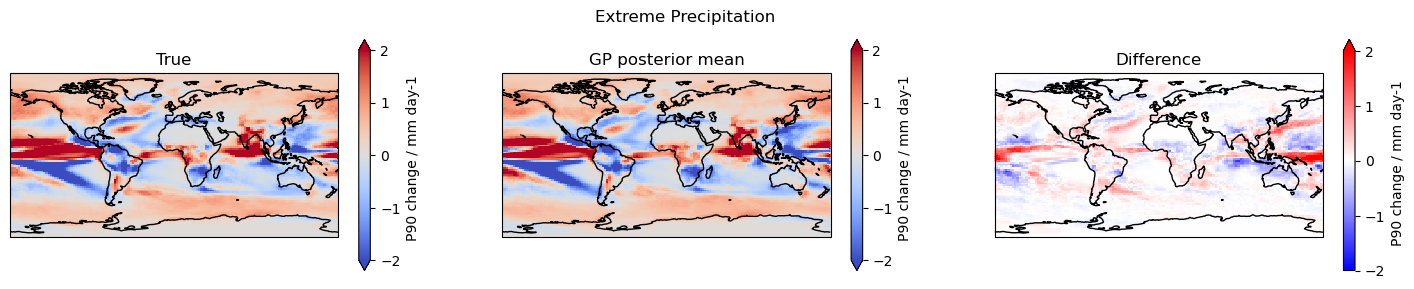

In [15]:
# plotting predictions
divnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=5)
diffnorm = colors.TwoSlopeNorm(vmin=-2., vcenter=0., vmax=2)

## Temperature
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(18, 3))
fig.suptitle('Extreme Precipitation')

# Test
plt.subplot(131, projection=proj)
pr90_truth.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='True')

# Emulator
plt.subplot(132, projection=proj)
posterior_pr90_data.sel(time=slice(2050,None)).mean('time').plot(cmap="coolwarm", vmin=-2,
                              cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='GP posterior mean')

# Difference
difference = pr90_truth - posterior_pr90_data
plt.subplot(133, projection=proj)
difference.sel(time=slice(2050,None)).mean('time').plot(cmap="bwr", norm=diffnorm,
                cbar_kwargs={"label":"P90 change / mm day-1 "})
plt.gca().coastlines()
plt.setp(plt.gca(), title='Difference')

__Feature importance__
- CO2 (0.48)
- SO2 (1.20)
- Significant internal variability (0.46)

In [16]:
model

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.c,Parameter,Identity,,True,"(1,)",float64,[-0.01684]
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.85473
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,5.18163
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.0001
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,8.7753
GPR.kernel.kernels[2].variance,Parameter,Softplus,,True,(),float64,0.07209
GPR.kernel.kernels[2].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[3.18397, 6.92961, 5.73099..."
GPR.kernel.kernels[3].variance,Parameter,Softplus,,True,(),float64,0.02568
GPR.kernel.kernels[3].lengthscales,Parameter,Softplus,,True,"(5,)",float64,"[1.90036, 2.40945, 3.32326..."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.82957


In [17]:
# Save predictions
posterior_pr90_data.to_netcdf('climatebench-gp-posterior-mean-pr90-test-2019-2100.nc')
posterior_pr90_std_data.to_netcdf('climatebench-gp-posterior-std-pr90-test-2019-2100.nc')